In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,21), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'nearSurfRain_TRMM',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdVar2hr_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_QSandTRMM_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,20):
            if i <= 9:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

102 (2935, 21)
(2833, 21)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [5]:
df

time  lat    lon    U10N_QS  U10N_dir_QS  nearSurfRain_TRMM  \
0     318514200.0 -8.0  265.0   5.287187   337.002319                0.0   
1     320242200.0 -8.0  265.0   5.750369   283.500000                0.0   
2     320457600.0 -8.0  265.0   6.740190   317.911682                0.0   
3     320458200.0 -8.0  265.0   6.740190   317.911682                0.0   
4     326462400.0 -8.0  265.0   8.683150   317.524170                0.0   
...           ...  ...    ...        ...          ...                ...   
2828  525627000.0  9.0  220.0   6.629283    24.173828                0.0   
2829  531719400.0  9.0  220.0   8.212992   233.262543                0.0   
2830  534006000.0  9.0  220.0  10.973951   248.491196                0.0   
2831  536254200.0  9.0  220.0  10.208716   233.618240                0.0   
2832  536254800.0  9.0  220.0  10.208716   233.618240                0.0   

      satTimeDiff      dist      satLon    satLat  ...  U10N_y_TAO2  \
0           356.0  6.190111  264.965363 -8.043848  ...     3.970543   
1           281.0  1.887062  265.005981 -7.984097  ...     4.342545   
2           383.0  4.686291  265.026001 -7.966636  ...     4.565930   
3          -217.0  4.686291  265.026001 -7.966636  ...     5.635839   
4           437.0  4.599195  264.960663 -8.013906  ...     5.750393   
...           ...       ...         ...       ...  ...          ...   
2828       -310.0  1.996669  220.015366  9.009598  ...    -0.666660   
2829       -488.0  4.181105  220.016586  8.966155  ...    -5.510837   
2830        572.0  3.175671  220.004898  8.971853  ...    -4.584487   
2831        314.0  4.751151  220.041916  9.010573  ...    -7.626215   
2832       -286.0  4.751151  220.041916  9.010573  ...    -7.127543   

        SST_TAO     RH_TAO   AIRT_TAO  wspdVar2hr_TAO  Deployment Classifier  \
0     25.548000  81.220001  24.559999        0.309169                    0.0   
1     26.716000  85.550003  25.309999        0.040242                    0.0   
2     26.857000  83.199997  26.469999        0.175109                    0.0   
3     26.843000  82.910004  26.440001        0.154050                    0.0   
4     26.385000  85.209999  25.360001        0.156337                    1.0   
...         ...        ...        ...             ...                    ...   
2828  28.419001  87.610001  25.150000        2.347693                    9.0   
2829  27.420000  84.459999  27.200001        0.209599                   10.0   
2830  27.427000  87.510002  27.020000        0.548763                   10.0   
2831  26.841999  85.110001  26.260000        0.232241                   10.0   
2832  26.839001  84.690002  26.360001        0.161078                   10.0   

      speedDiff  absSpeedDiff  directionDiff  absDirectionDiff  
0      0.354563      0.354563      13.302307         13.302307  
1      0.685842      0.685842     -45.600006         45.600006  
2      0.365329      0.365329       2.111694          2.111694  
3     -0.378188      0.378188      -4.388306          4.388306  
4     -0.743507      0.743507      10.024170         10.024170  
...         ...           ...            ...               ...  
2828   2.399763      2.399763     -74.826172         74.826172  
2829  -0.746082      0.746082       1.262543          1.262543  
2830   1.159403      1.159403       6.391190          6.391190  
2831   0.325358      0.325358      14.118240         14.118240  
2832   0.464644      0.464644      10.618240         10.618240  

[2833 rows x 25 columns]

In [6]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]

In [7]:
X.head()

speedDiff  directionDiff
0   0.354563      13.302307
1   0.685842     -45.600006
2   0.365329       2.111694
3  -0.378188      -4.388306
4  -0.743507      10.024170

In [8]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [9]:
normX

speedDiff  directionDiff
0      0.087991       0.393364
1      0.347024      -1.581070
2      0.096409       0.018250
3     -0.484962      -0.199634
4     -0.770611       0.283480
...         ...            ...
2828   1.687171      -2.560746
2829  -0.772625      -0.010214
2830   0.717311       0.161700
2831   0.065154       0.420715
2832   0.174065       0.303393

[2833 rows x 2 columns]

In [10]:
# normX['errorFrmNorm'] = np.sqrt(normX['absSpeedDiff']**2 + normX['absDirectionDiff']**2)
# X=normX['errorFrmNorm']

In [11]:
# Y = X.to_numpy()

In [12]:
# Y = np.array([Y]).transpose()
# Y.shape

(0.24195283136383533, 1.2788979027850342, 0.8340230829980033)

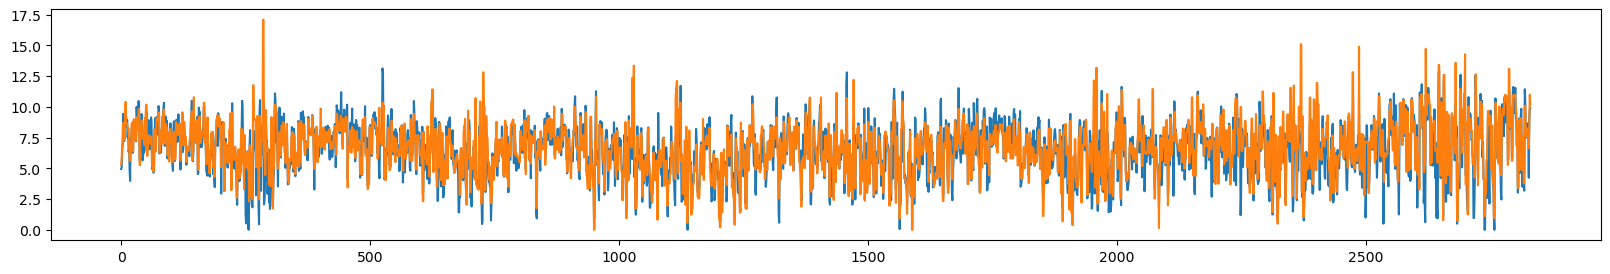

In [13]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_TAO'][n1:n2])
plt.plot(df['U10N_QS'][n1:n2])
np.mean(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.std(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.corrcoef(df['U10N_TAO'][n1:n2], df['U10N_QS'][n1:n2])[0,1]

(6.521695955409169, 56.00728131450041, 0.7116400913273405)

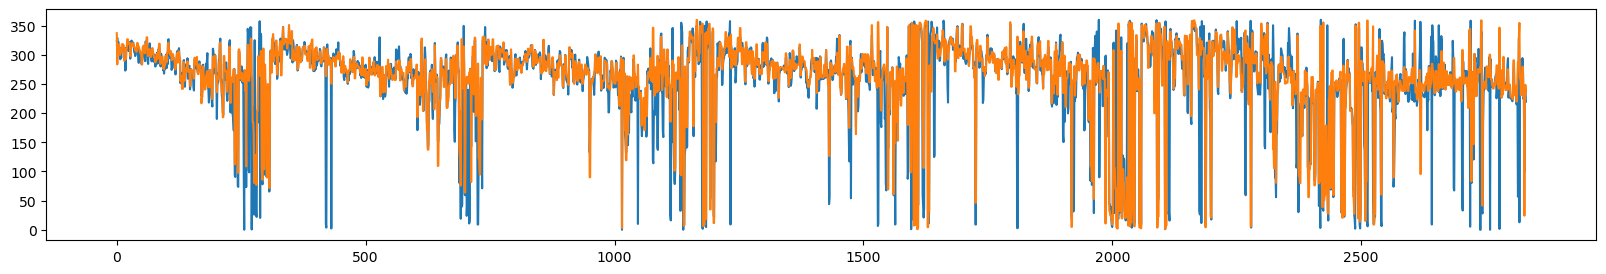

In [14]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_dir_TAO'][n1:n2])
plt.plot(df['U10N_dir_QS'][n1:n2])
np.mean(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.std(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.corrcoef(df['U10N_dir_TAO'][n1:n2], df['U10N_dir_QS'][n1:n2])[0,1]

In [15]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [16]:
def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    subDF = subDF.loc[subDF['label'] == cluster_label]

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'

    
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = Dataset(deployFileName)
    startDates = np.array(ds2.variables['startDate'])
    units = ds2.variables['startDate'].units
    cftimes = num2date(startDates, units)
    startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    endDates = np.array(ds2.variables['endDate'])
    units = ds2.variables['endDate'].units
    cftimes = num2date(endDates, units)
    endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    ds2.close()
    
    cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
    dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']

    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        ax1.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        ax2.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
    #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

    ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
    ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
    ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
    ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
    ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

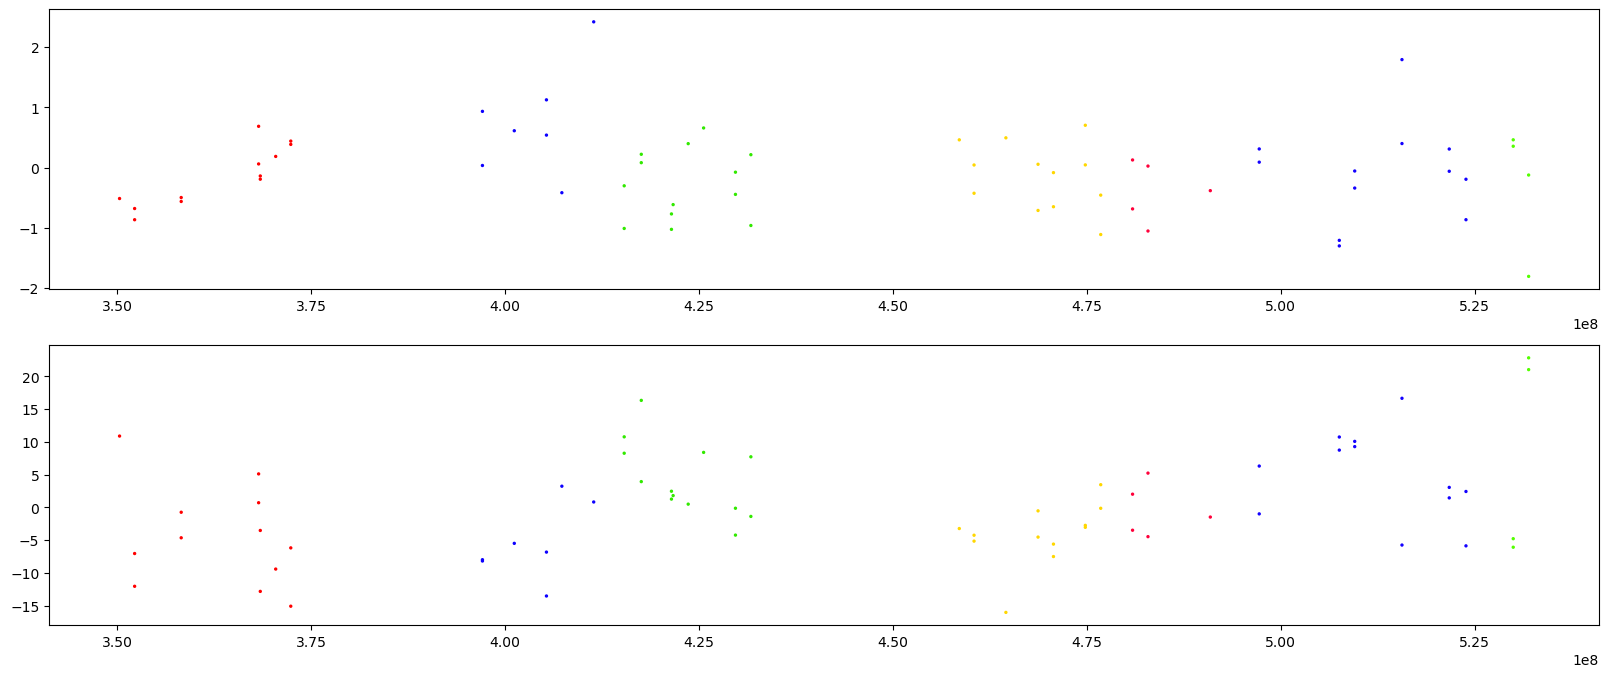

In [17]:
lat = -2
lon = -140

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

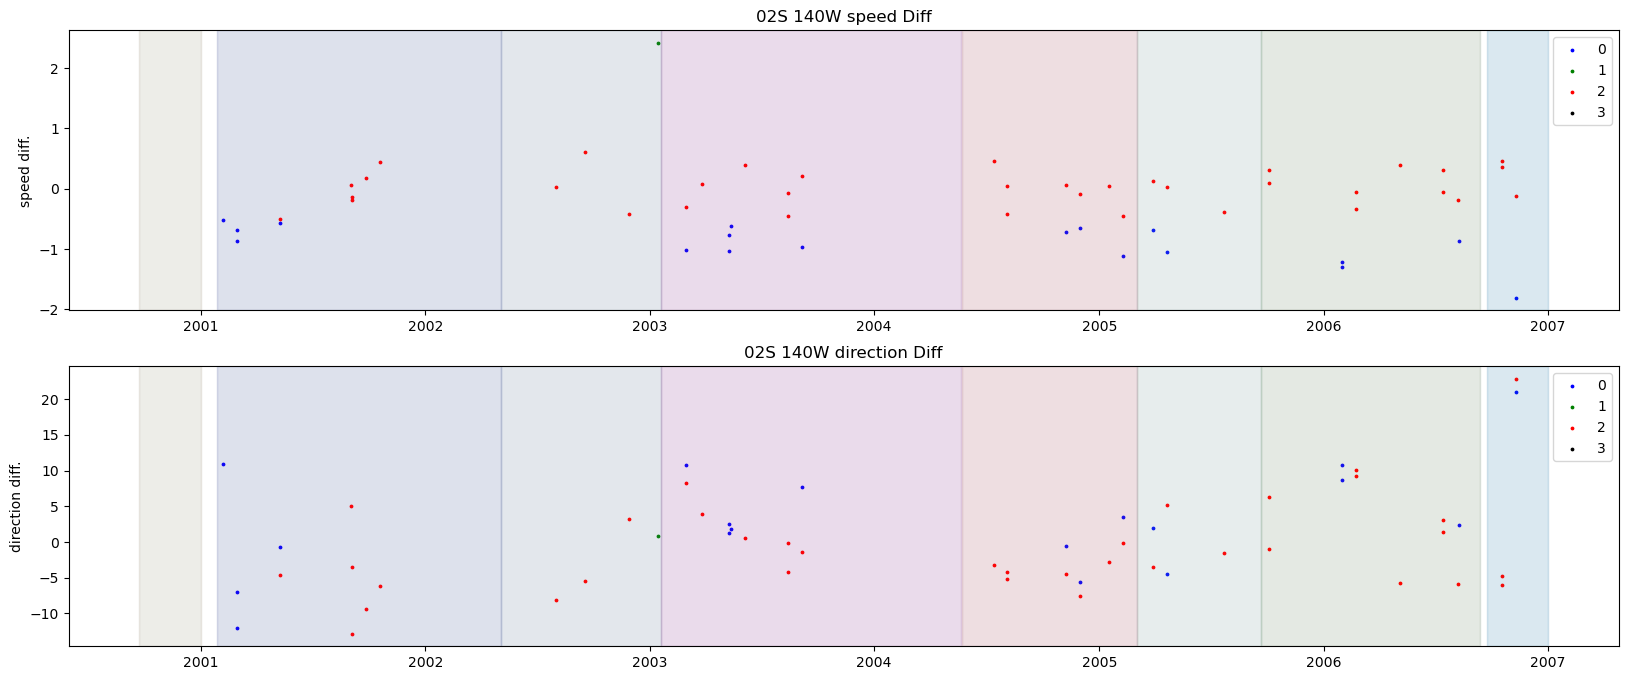

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3, color = 'black')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
axes[0].set_ylabel('speed diff.')
axes[0].legend()

axes[1].set_ylabel('direction diff.')
axes[1].legend()

In [19]:
df.head()

time  lat    lon   U10N_QS  U10N_dir_QS  nearSurfRain_TRMM  \
0  318514200.0 -8.0  265.0  5.287187   337.002319                0.0   
1  320242200.0 -8.0  265.0  5.750369   283.500000                0.0   
2  320457600.0 -8.0  265.0  6.740190   317.911682                0.0   
3  320458200.0 -8.0  265.0  6.740190   317.911682                0.0   
4  326462400.0 -8.0  265.0  8.683150   317.524170                0.0   

   satTimeDiff      dist      satLon    satLat  ...  SST_TAO     RH_TAO  \
0        356.0  6.190111  264.965363 -8.043848  ...   25.548  81.220001   
1        281.0  1.887062  265.005981 -7.984097  ...   26.716  85.550003   
2        383.0  4.686291  265.026001 -7.966636  ...   26.857  83.199997   
3       -217.0  4.686291  265.026001 -7.966636  ...   26.843  82.910004   
4        437.0  4.599195  264.960663 -8.013906  ...   26.385  85.209999   

    AIRT_TAO  wspdVar2hr_TAO  Deployment Classifier  speedDiff  absSpeedDiff  \
0  24.559999        0.309169                    0.0   0.354563      0.354563   
1  25.309999        0.040242                    0.0   0.685842      0.685842   
2  26.469999        0.175109                    0.0   0.365329      0.365329   
3  26.440001        0.154050                    0.0  -0.378188      0.378188   
4  25.360001        0.156337                    1.0  -0.743507      0.743507   

   directionDiff  absDirectionDiff  label  
0      13.302307         13.302307      8  
1     -45.600006         45.600006      4  
2       2.111694          2.111694      2  
3      -4.388306          4.388306      2  
4      10.024170         10.024170      0  

[5 rows x 26 columns]

In [20]:
import seaborn as sns

In [21]:
#sns.pairplot(data=df, x = 'hue="label")

In [22]:
subDFheaders = ['satTimeDiff',
                 'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 'absSpeedDiff',
                 'absDirectionDiff',
                 'label']

subDFheaders = [ 'satTimeDiff',
                 'dist',
                 # 'SST_TAO',
                 # 'RH_TAO',
                 # 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 #'absSpeedDiff',
                 #'absDirectionDiff',
                 'label']

subDF = df[subDFheaders]

In [23]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [24]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [25]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [26]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [27]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [28]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [29]:
# xlabel = 'directionDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [30]:
# xlabel = 'speedDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [31]:
# xlabel = 'absSpeedDiff'
# ylabel = 'absDirectionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [32]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_971799/2479521613.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('

Text(0, 0.5, 'QS direction - TAO direction [Degrees]')

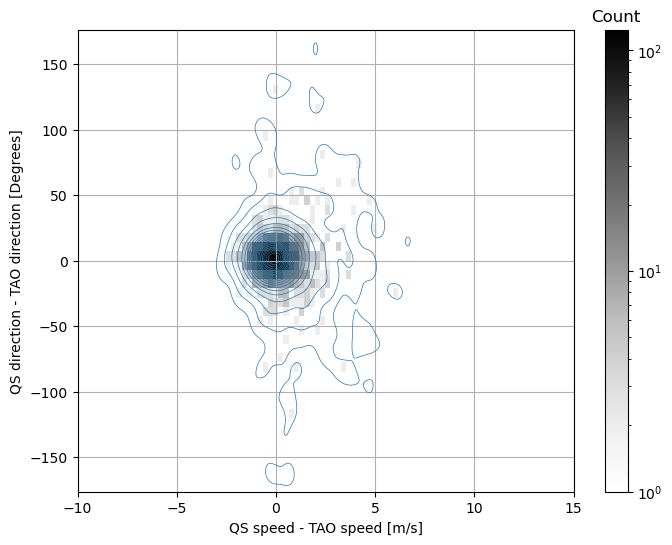

In [33]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'

cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
cb = plt.colorbar(h1[3], ax = ax)
cb.ax.set_title('Count')

sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlim(-10,15)
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')
#plt.savefig('PDF_byCluster.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

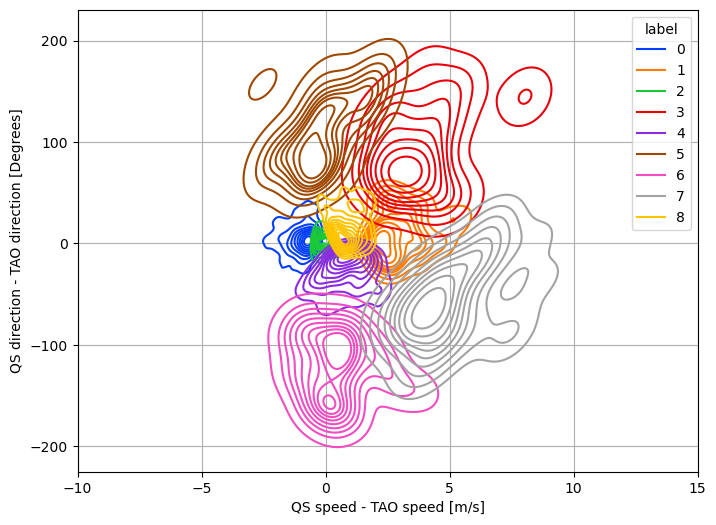

In [34]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')
ax.set_xlim(-10,15)
plt.savefig('PDF_byCluster.png', dpi=100)


In [35]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# subdf = df.loc[df['label'].isin([0,2,3,5,6,8])]
# s = sns.kdeplot(subdf, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_971799/3285238641.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = tips.groupby(['day'])['total_bill'].median()
/tmp/ipy

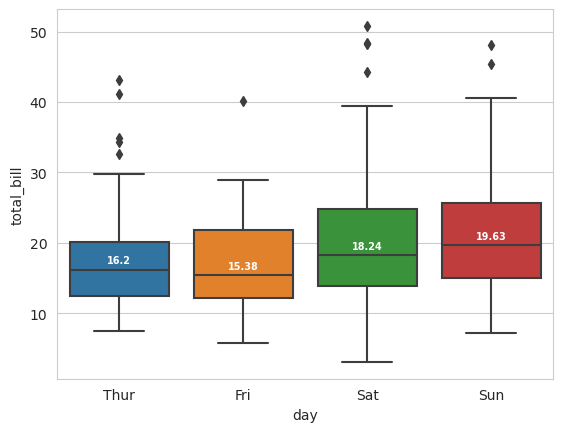

In [36]:
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
box_plot = sns.boxplot(x="day",y="total_bill",data=tips)

medians = tips.groupby(['day'])['total_bill'].median()
vertical_offset = tips['total_bill'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [37]:
# fig, ax = plt.subplots(figsize = (20,15))
# box_plot = sns.boxplot(df, x="label",y="speedDiff", ax = ax)

# medians = df.groupby(['label'])['speedDiff'].median()
# vertical_offset = df['speedDiff'].median() * 0.05 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [38]:
var = 'speedDiff'
labelVal = 0

def getPDFplotFor(ax, df, labelVal, var):
    sns.histplot(df.loc[df['label'] == labelVal], x = var, ax = ax, bins = 50)
    ax.axvline(x = medians[labelVal], ymin= 0 , ymax = 0.25, color = 'r',  label = 'median')
    ax.axvline(x = means[labelVal], ymin= 0 , ymax = 0.25, color = 'blue',linestyle = '--', label = 'mean')
    ax.axvline(x = means[labelVal]-stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange', label = 'std. Dev')
    ax.axvline(x = means[labelVal]+stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange')
    
    text = f' mean: {means[labelVal]:6.2f} \n median: {medians[labelVal]:6.2f} \n stdDev: {stdDevs[labelVal]:6.2f}'
    
    
    ax.text(0.05, 0.95, text, horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha= 0.5))
    ax.legend(loc='upper right')

0 0
0 1
0 2
0 3
1 0


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 1
1 2


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 3


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


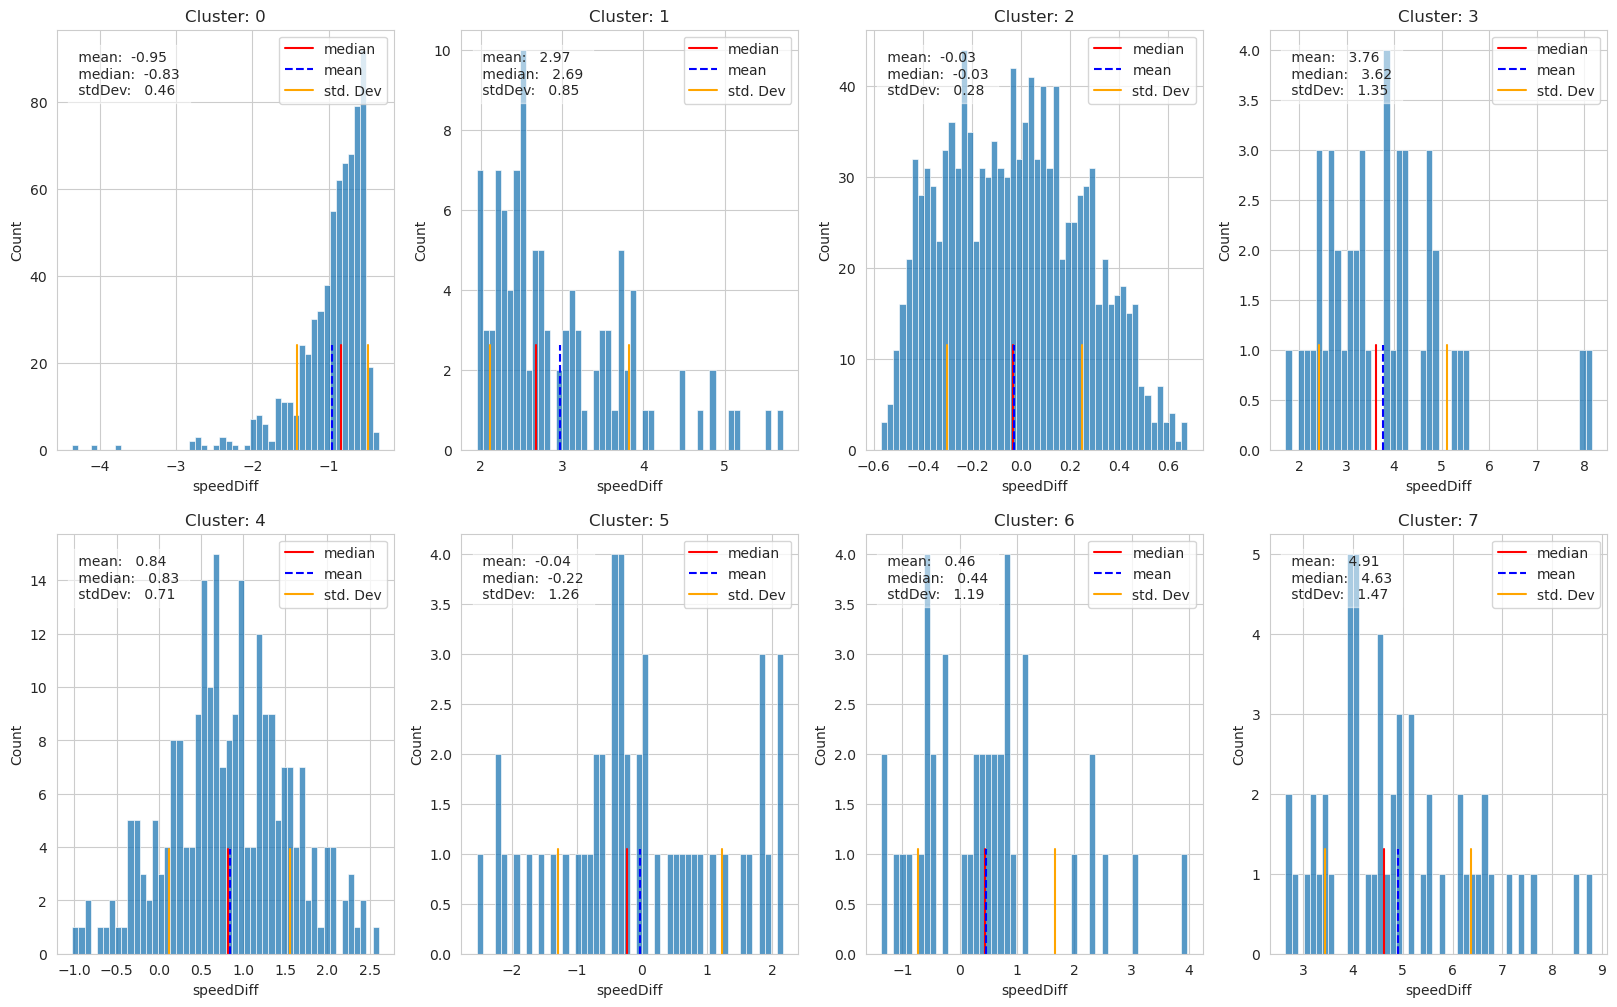

In [39]:
var = 'speedDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))
    

0 0
0 1
0 2
0 3
1 0


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 1
1 2
1 3


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

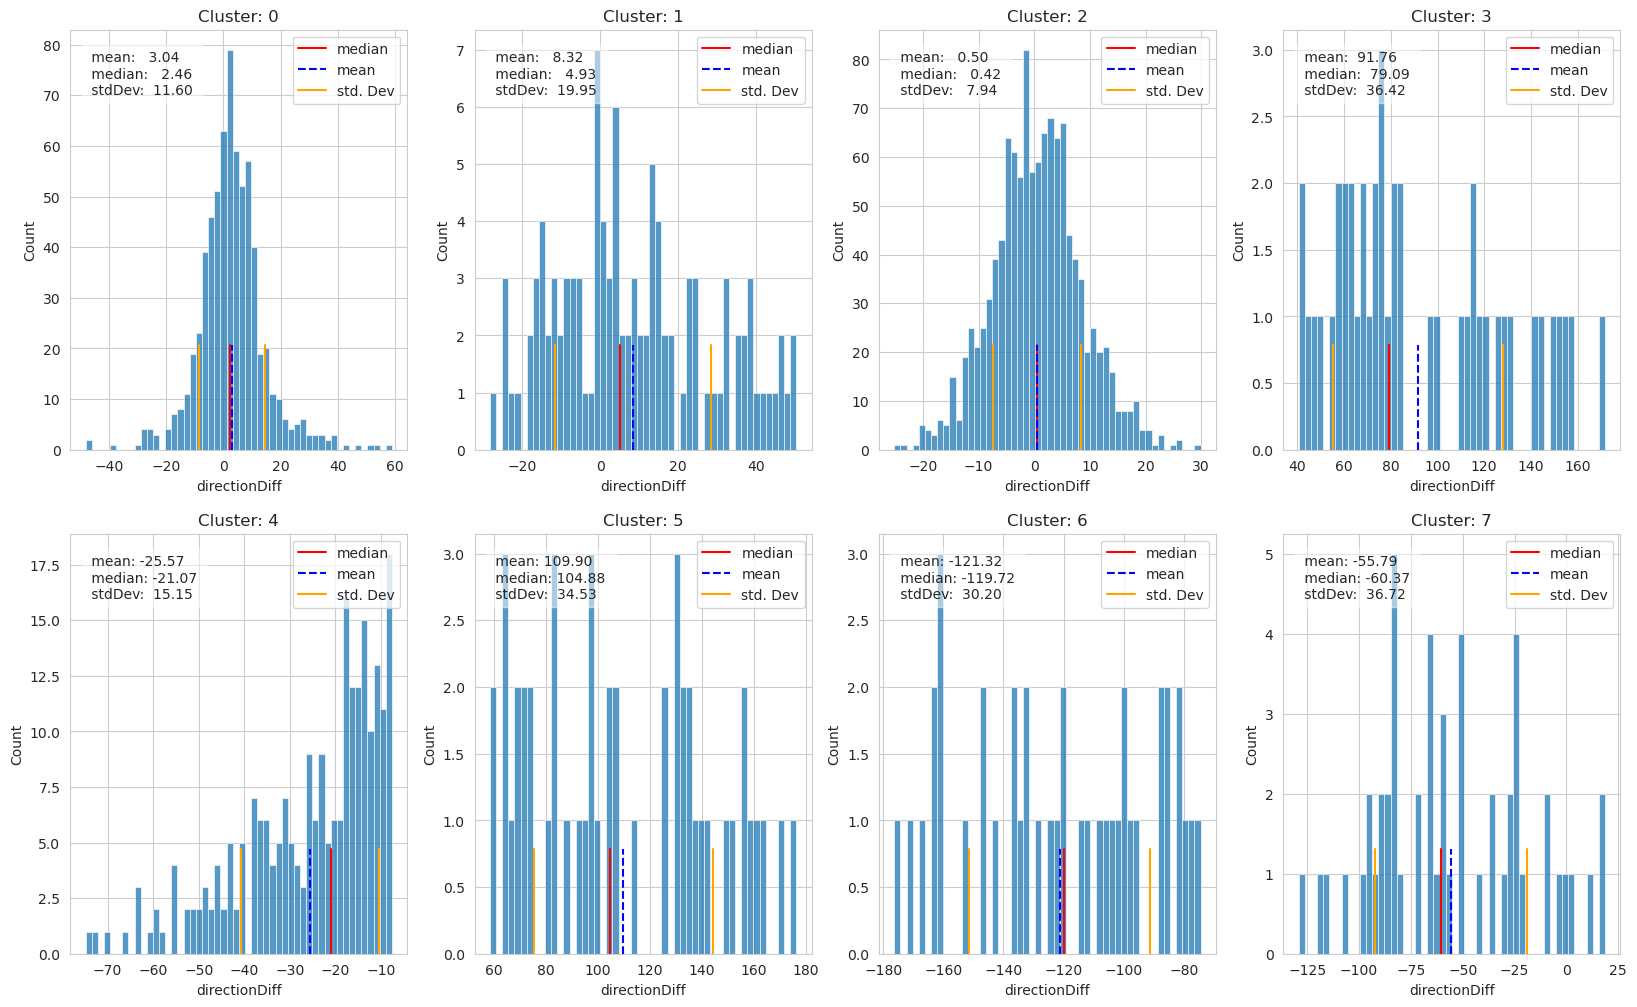

In [40]:
var = 'directionDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'cluster label')

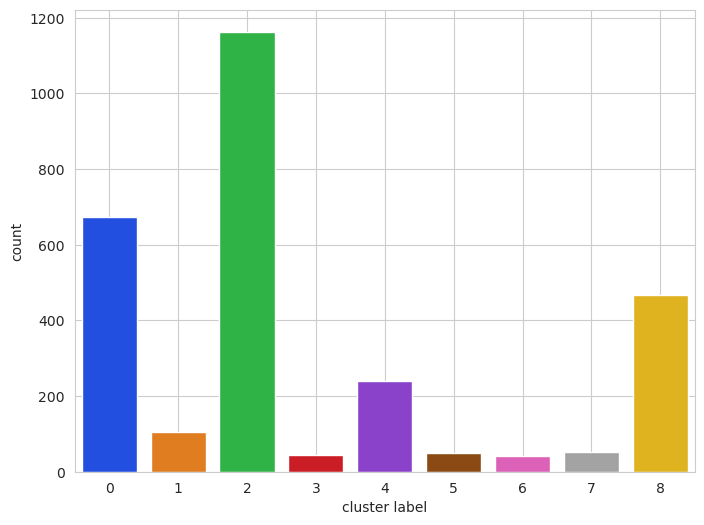

In [41]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

In [42]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
#mask = df['label'].isin([0,2,3,5,6,8])
mask = df['label'].isin([5,3,7,6])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad



2833


In [43]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        

        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999
    

In [44]:
getGoodBad(0, -140, df), getBadPercent(0, -140, df), 

(' 100,  0', 0.0)

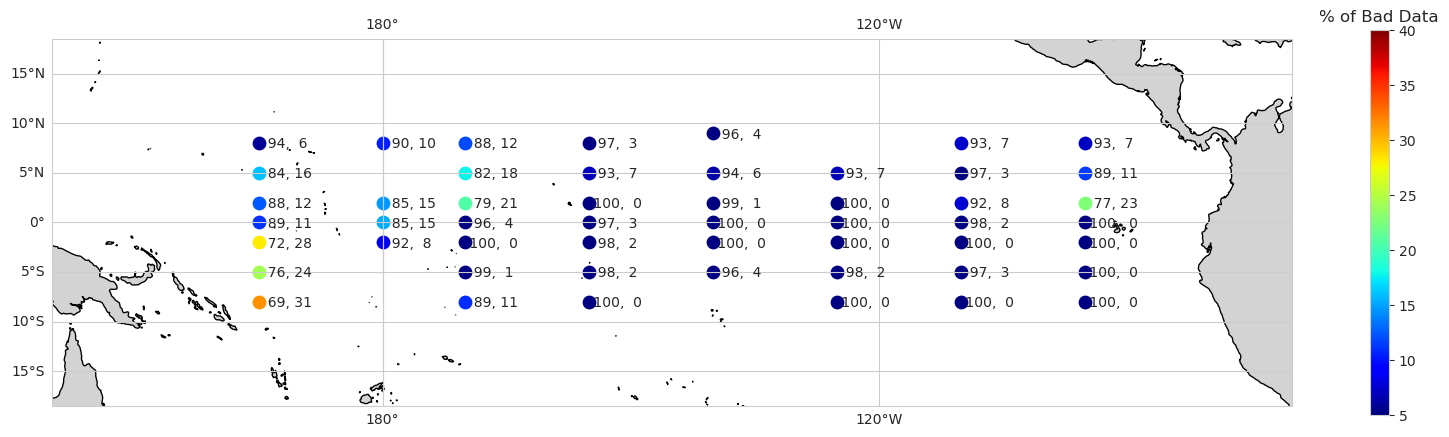

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad Data')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())


plt.savefig('goodVsBad.png', dpi=100)
    


In [46]:
cdfDates = num2date(df['time'], 'microseconds since 1900-01-01 00:00:00')
dateTime = np.array([datetime(cdf.year, cdf.month, cdf.day, cdf.hour, cdf.minute) for cdf in cdfDates])
day_of_year = np.array([date.timetuple().tm_yday for date in dateTime])
df['dateTime'] = dateTime
df['day'] = day_of_year

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0, 0.5, 'Bad Data %')

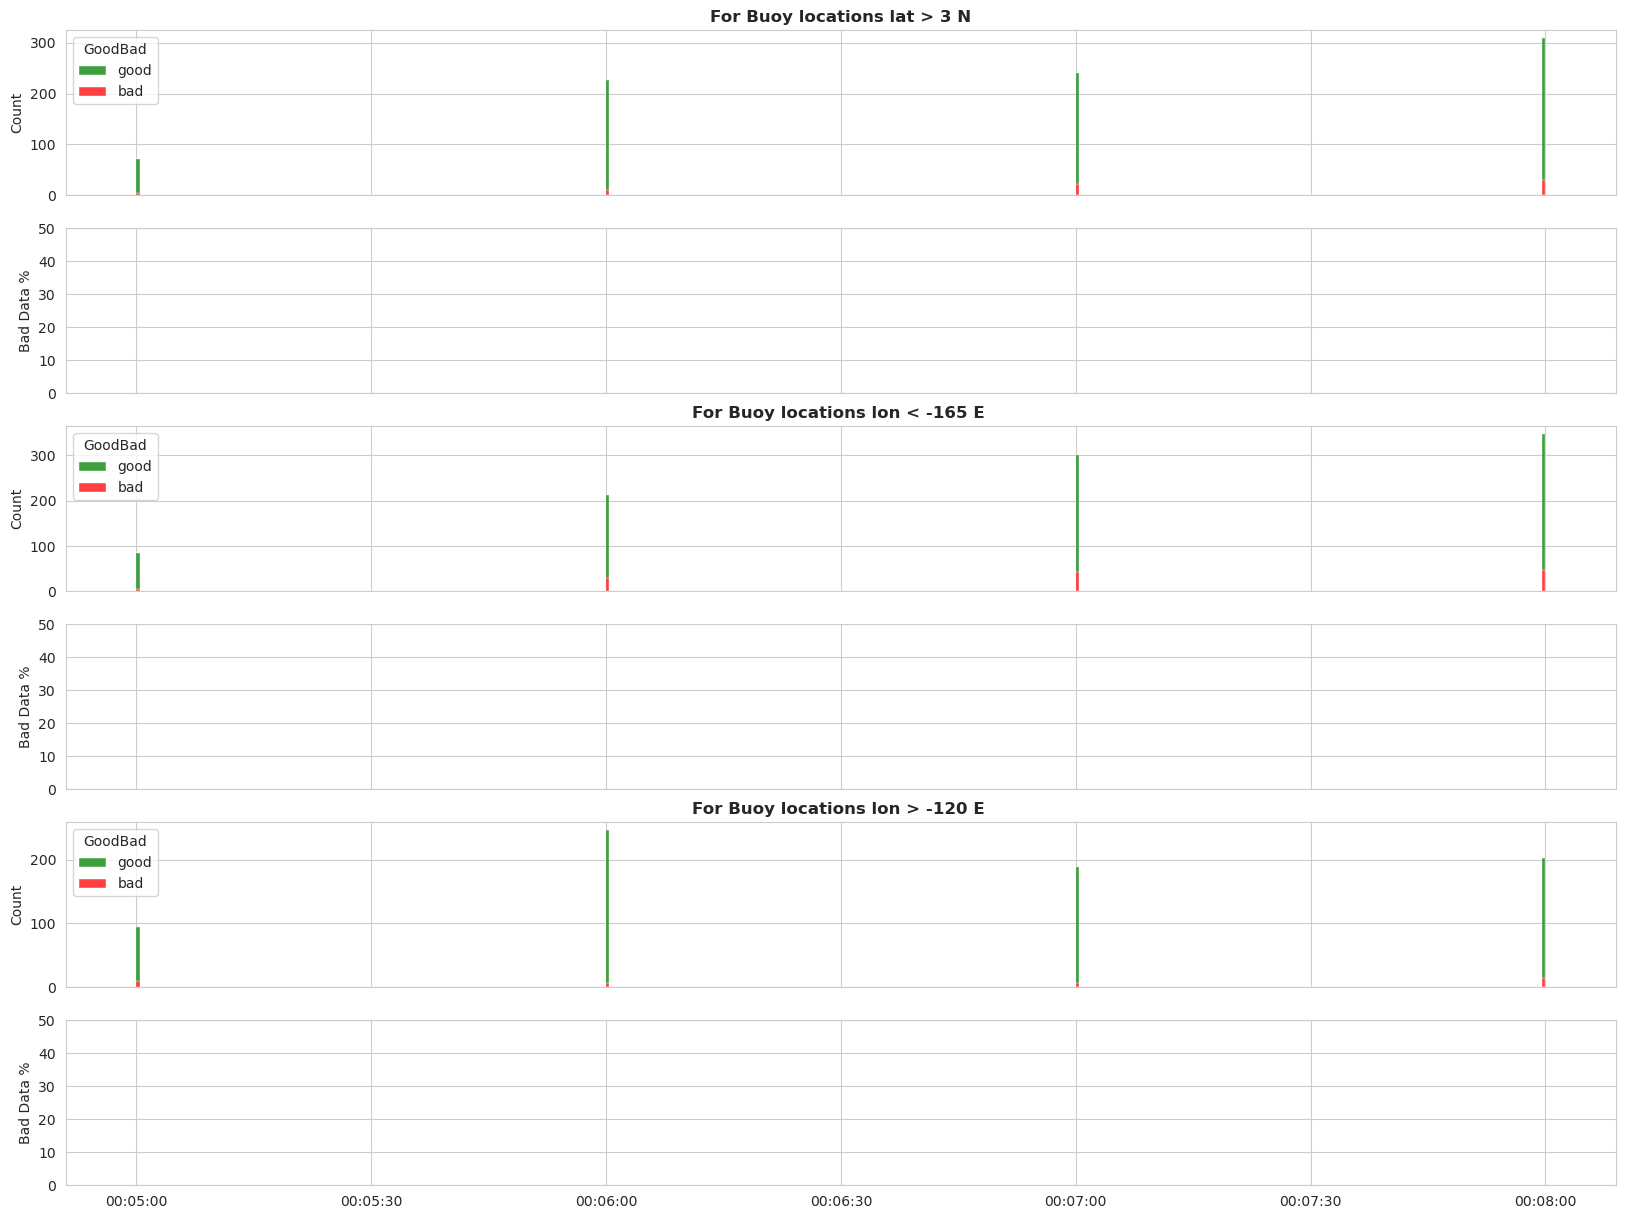

In [47]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

In [48]:
bin_edges[0:-1]

array([-25566.99652778, -25566.99652282, -25566.99651786, -25566.9965129 ,
       -25566.99650794, -25566.99650298, -25566.99649802, -25566.99649306,
       -25566.9964881 , -25566.99648313, -25566.99647817, -25566.99647321,
       -25566.99646825, -25566.99646329, -25566.99645833, -25566.99645337,
       -25566.99644841, -25566.99644345, -25566.99643849, -25566.99643353,
       -25566.99642857, -25566.99642361, -25566.99641865, -25566.99641369,
       -25566.99640873, -25566.99640377, -25566.99639881, -25566.99639385,
       -25566.99638889, -25566.99638393, -25566.99637897, -25566.99637401,
       -25566.99636905, -25566.99636409, -25566.99635913, -25566.99635417,
       -25566.99634921, -25566.99634425, -25566.99633929, -25566.99633433,
       -25566.99632937, -25566.9963244 , -25566.99631944, -25566.99631448,
       -25566.99630952, -25566.99630456, -25566.9962996 , -25566.99629464,
       -25566.99628968, -25566.99628472, -25566.99627976, -25566.9962748 ,
       -25566.99626984, -

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0.5, 0, 'Day of year')

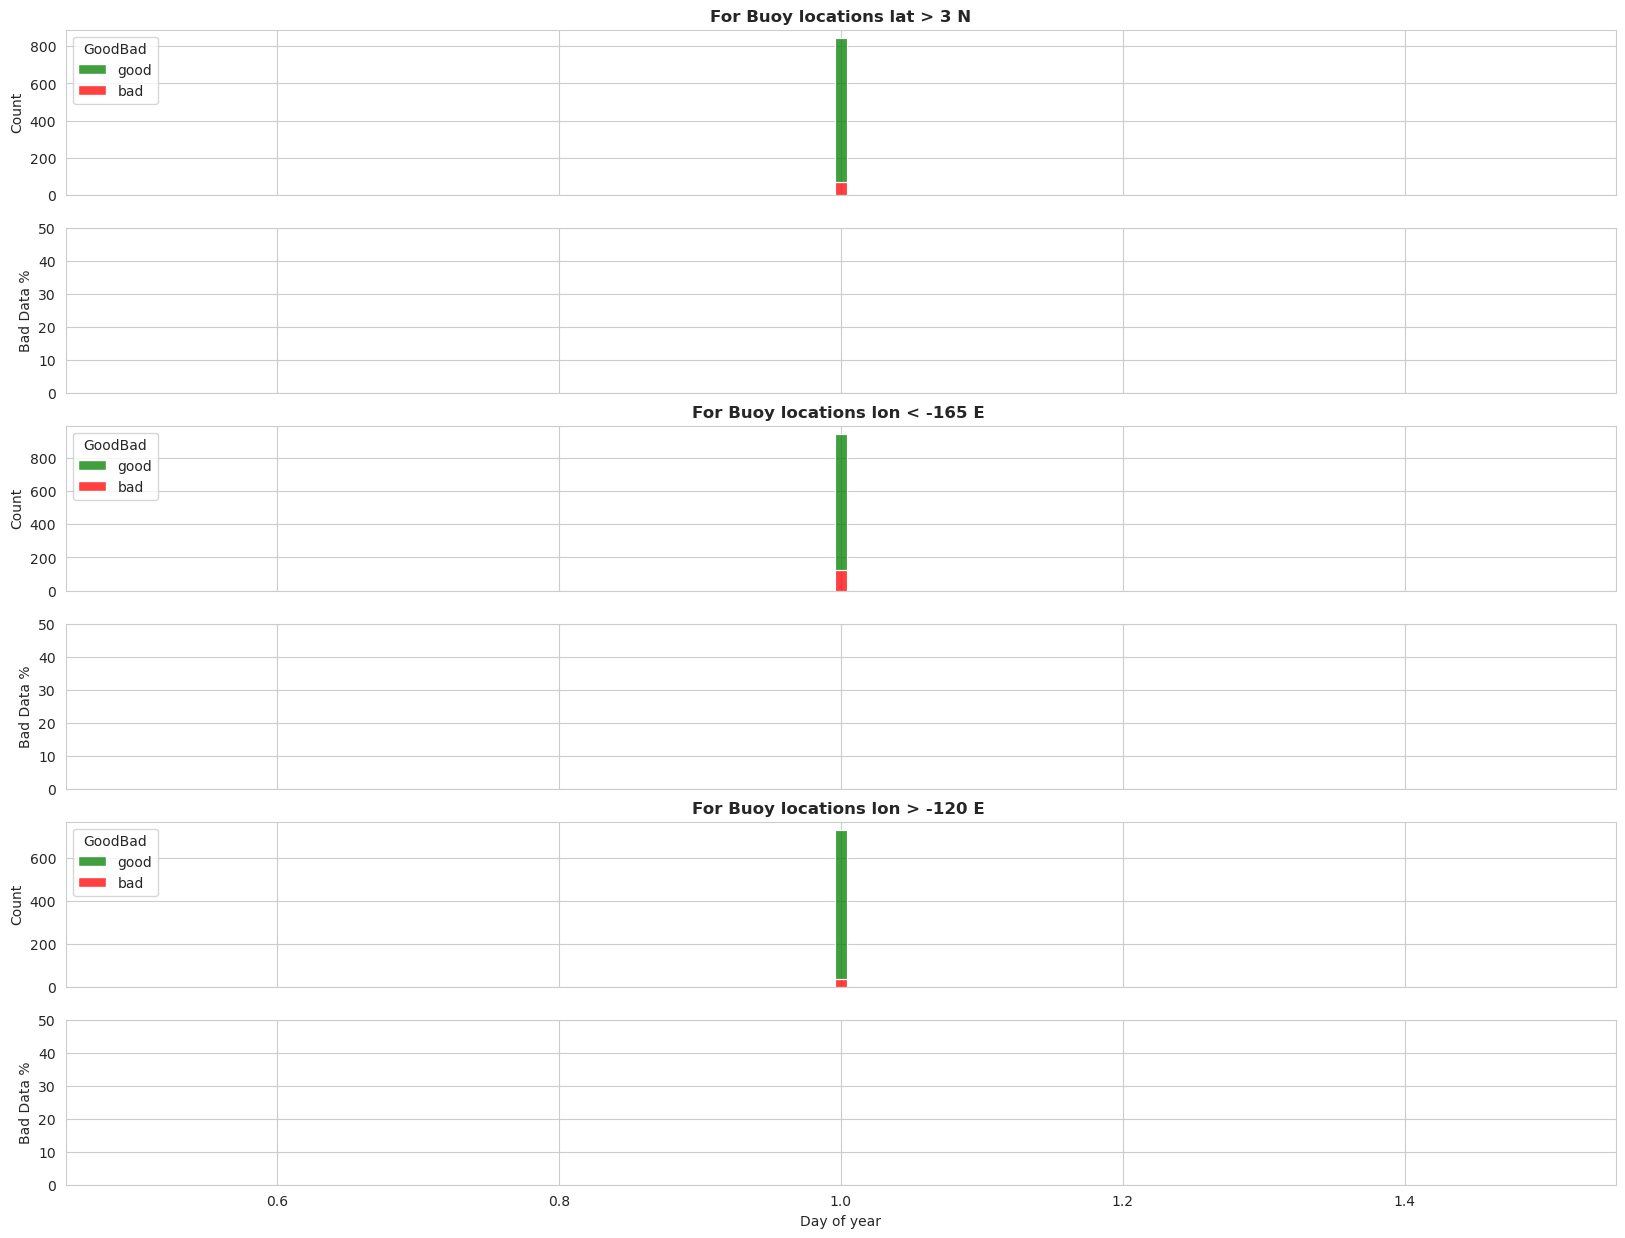

In [49]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = int(365//3)
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
################################################################################################

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_971799/1893293327.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

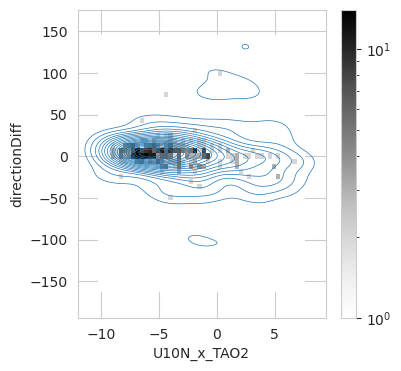

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    #ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

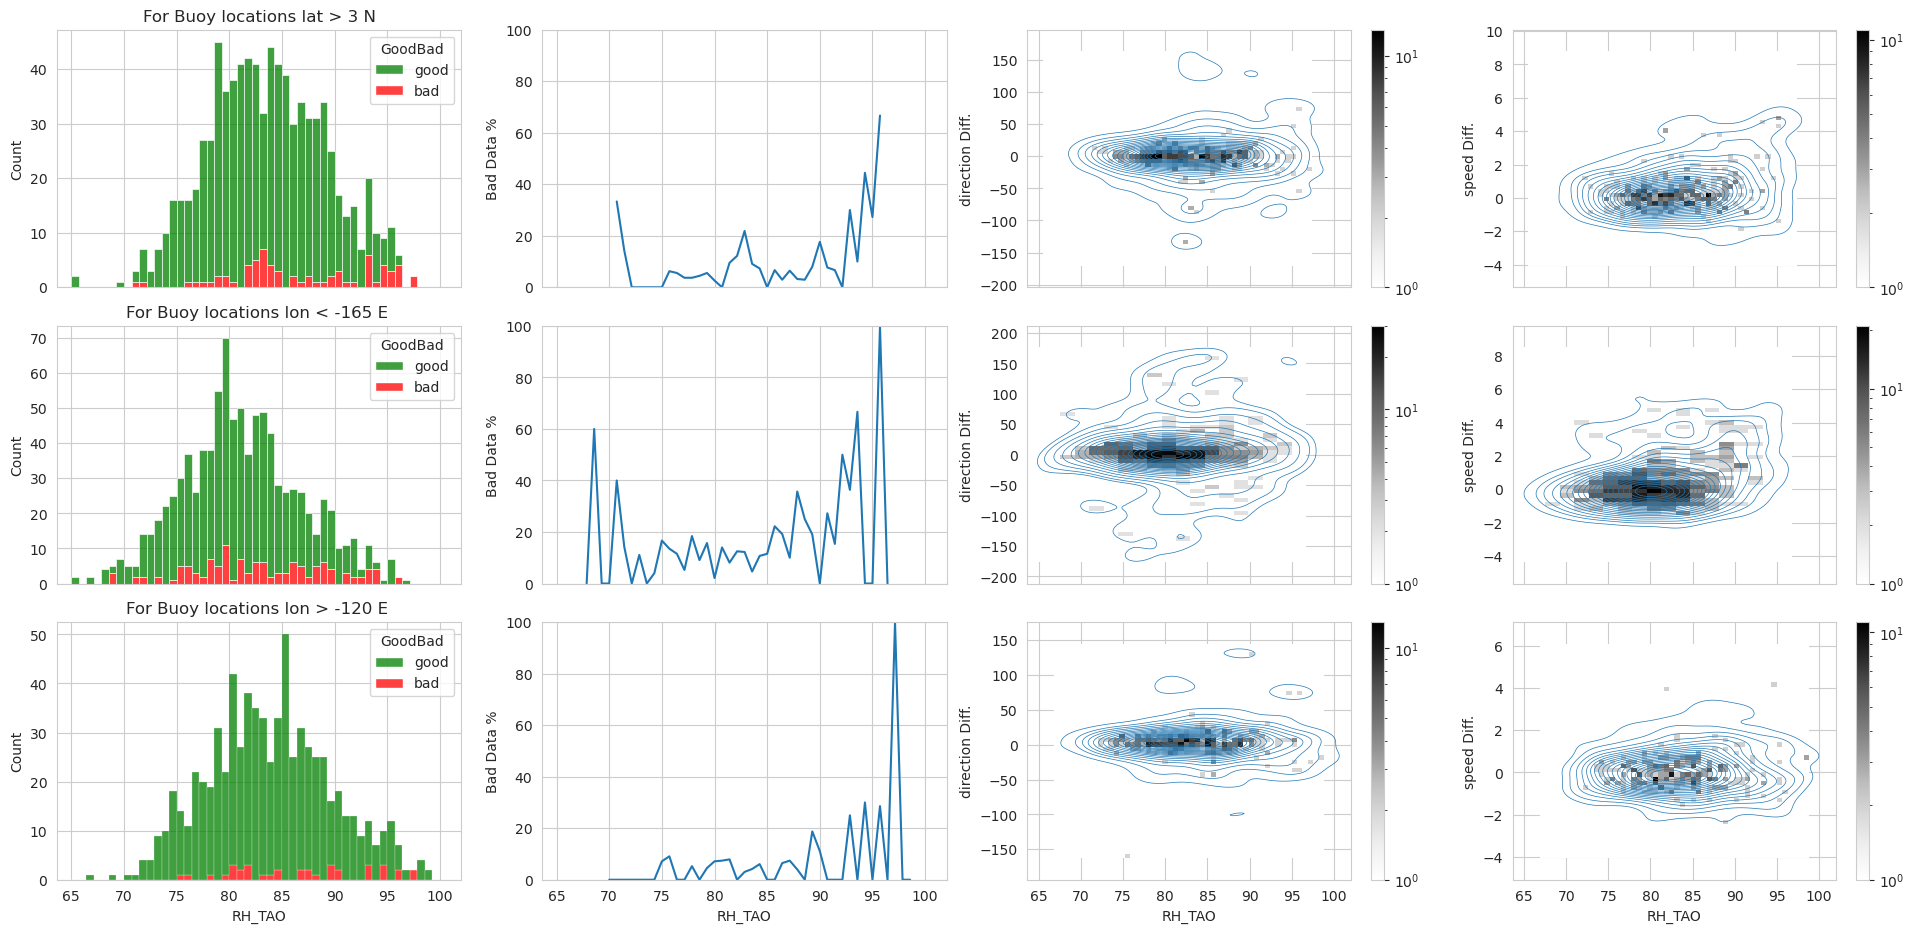

In [51]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(65,100,50)
ny = 10

xlabel = 'RH_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_RH.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

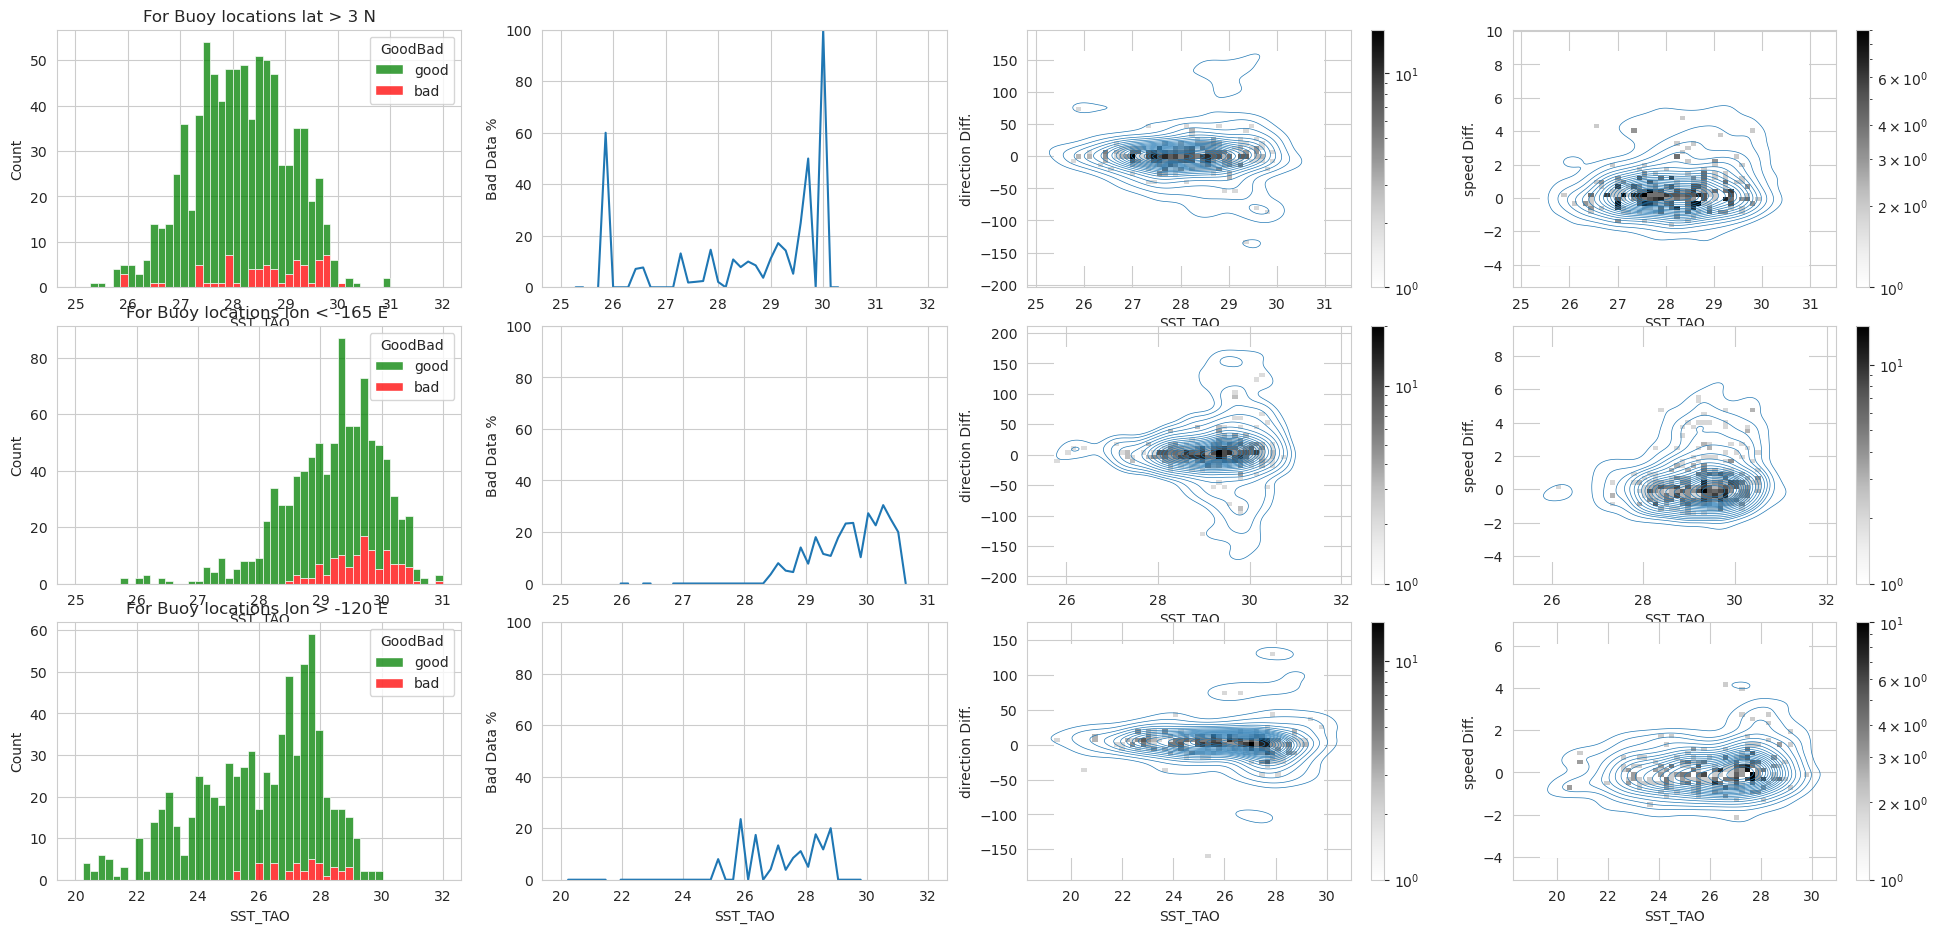

In [52]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_SST.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 0, '$\\degree C$')

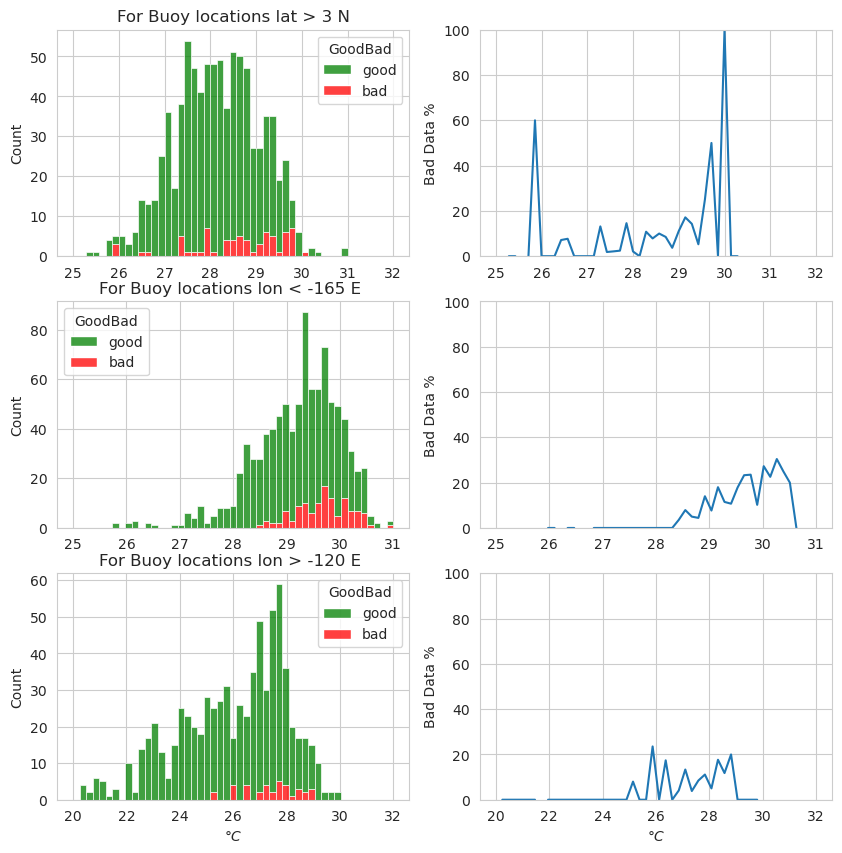

In [53]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = False, figsize=(10,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel(r'$\degree C$')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(r'$\degree C$')
################################################################################################


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

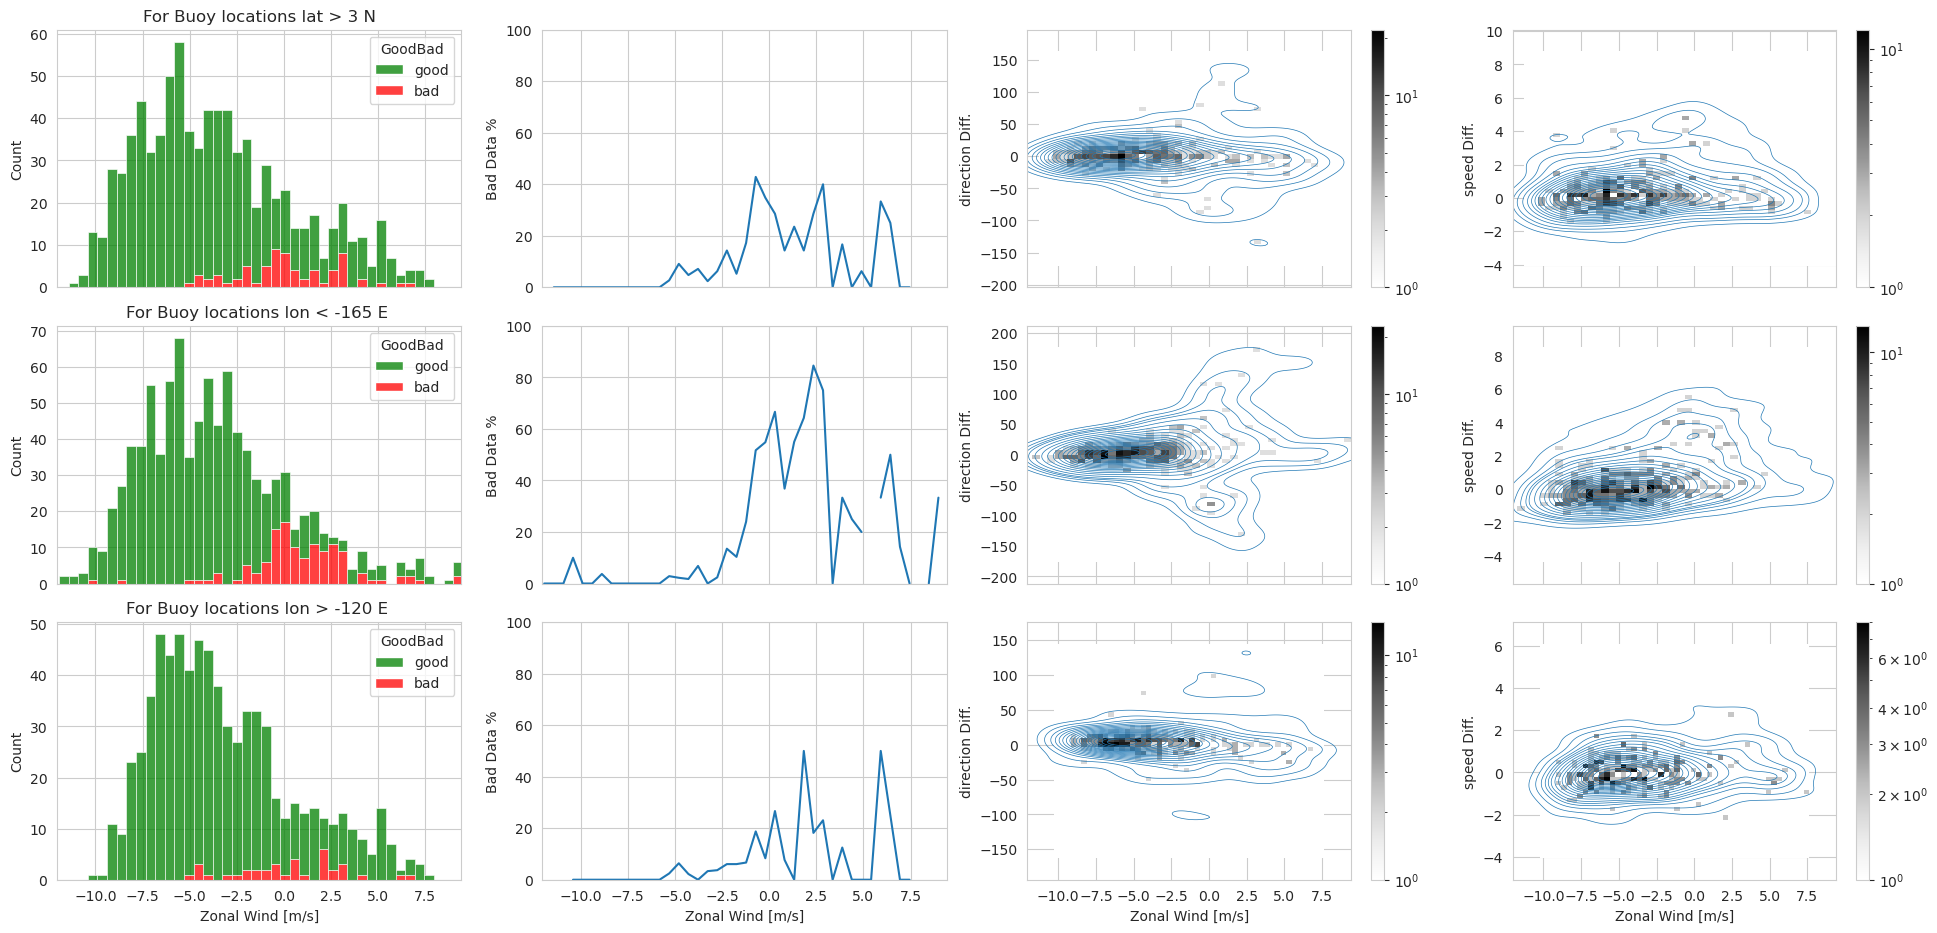

In [54]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_xlabel('Zonal Wind [m/s]')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_zonalWinds.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 0, 'Zonal Wind [m/s]')

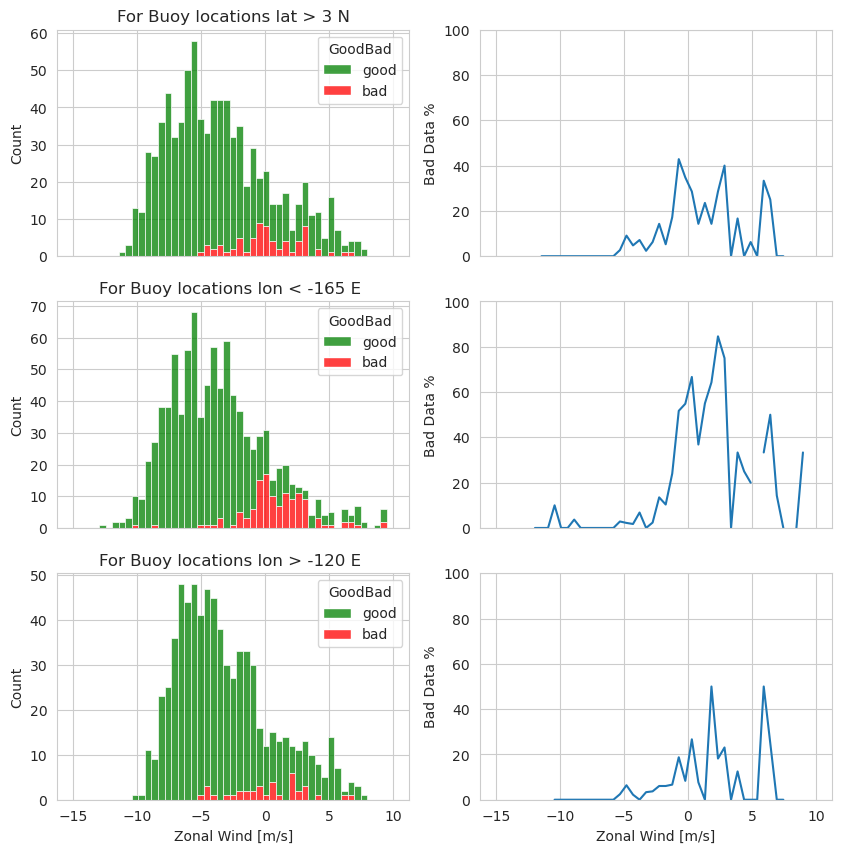

In [55]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = True, figsize=(10,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,10,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,15,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')
################################################################################################


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 0, 'near Surf Rain[mm/hr]')

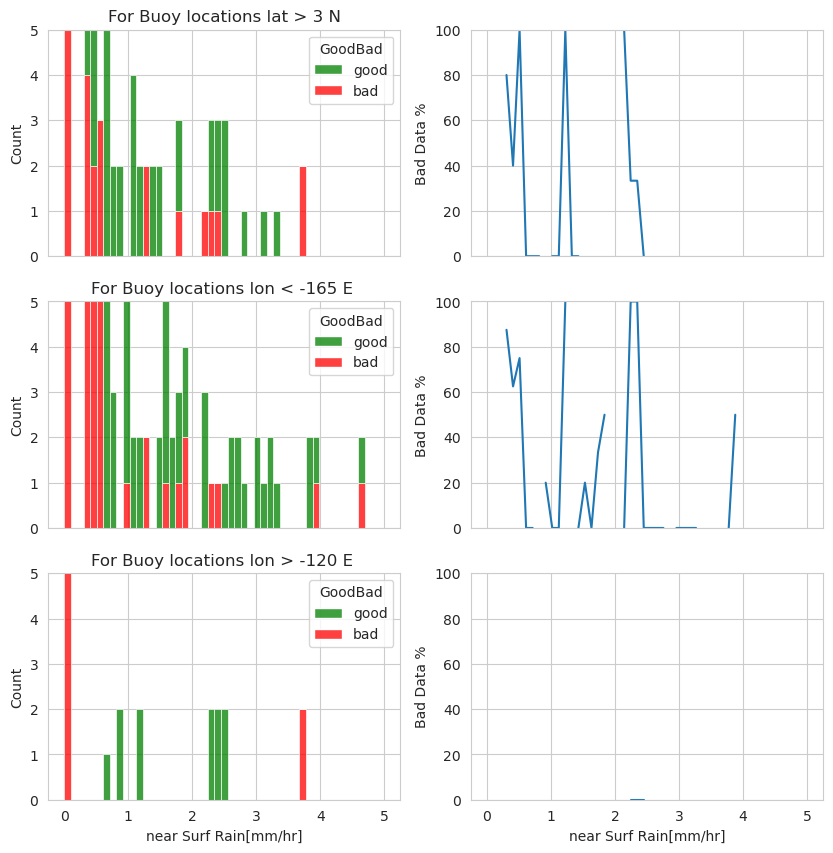

In [56]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = True, figsize=(10,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(0,5,50)
ny = 10

xlabel = 'nearSurfRain_TRMM'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')
ax.set_ylim(0,5)

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,10,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')
ax.set_ylim(0,5)

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,15,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('near Surf Rain[mm/hr]')
ax.set_ylim(0,5)

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('near Surf Rain[mm/hr]')
################################################################################################


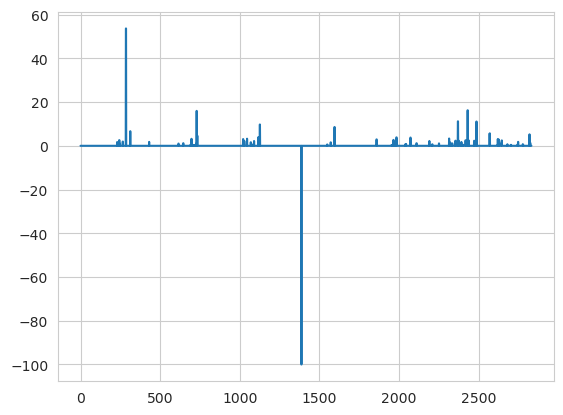

In [57]:
plt.plot(df['nearSurfRain_TRMM'])

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_971799/3600693425.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

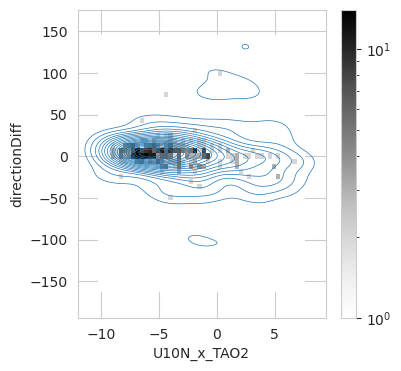

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

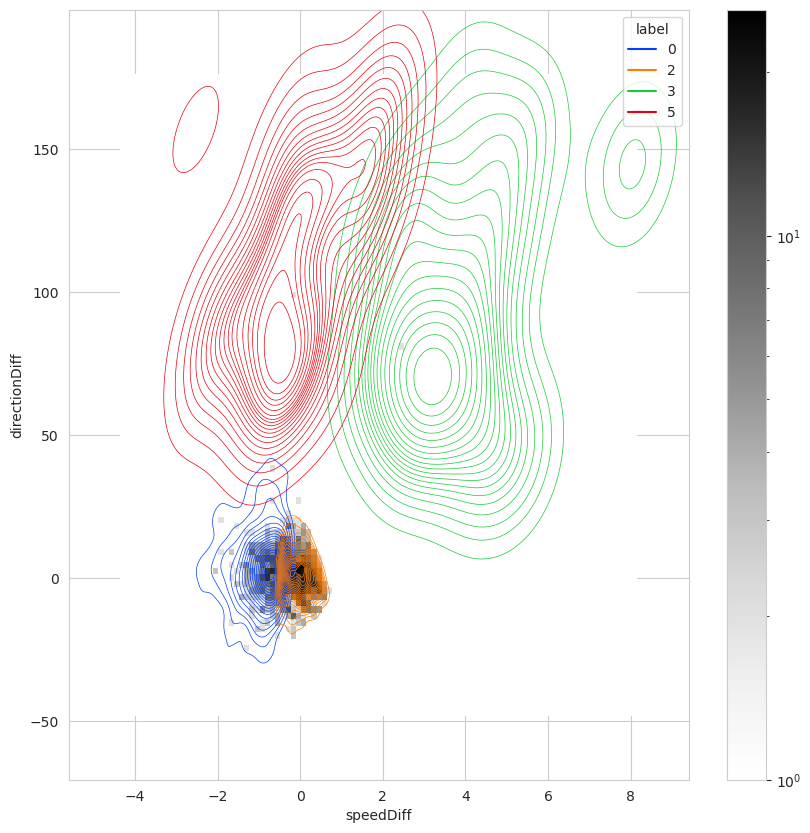

In [59]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [60]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [61]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [62]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

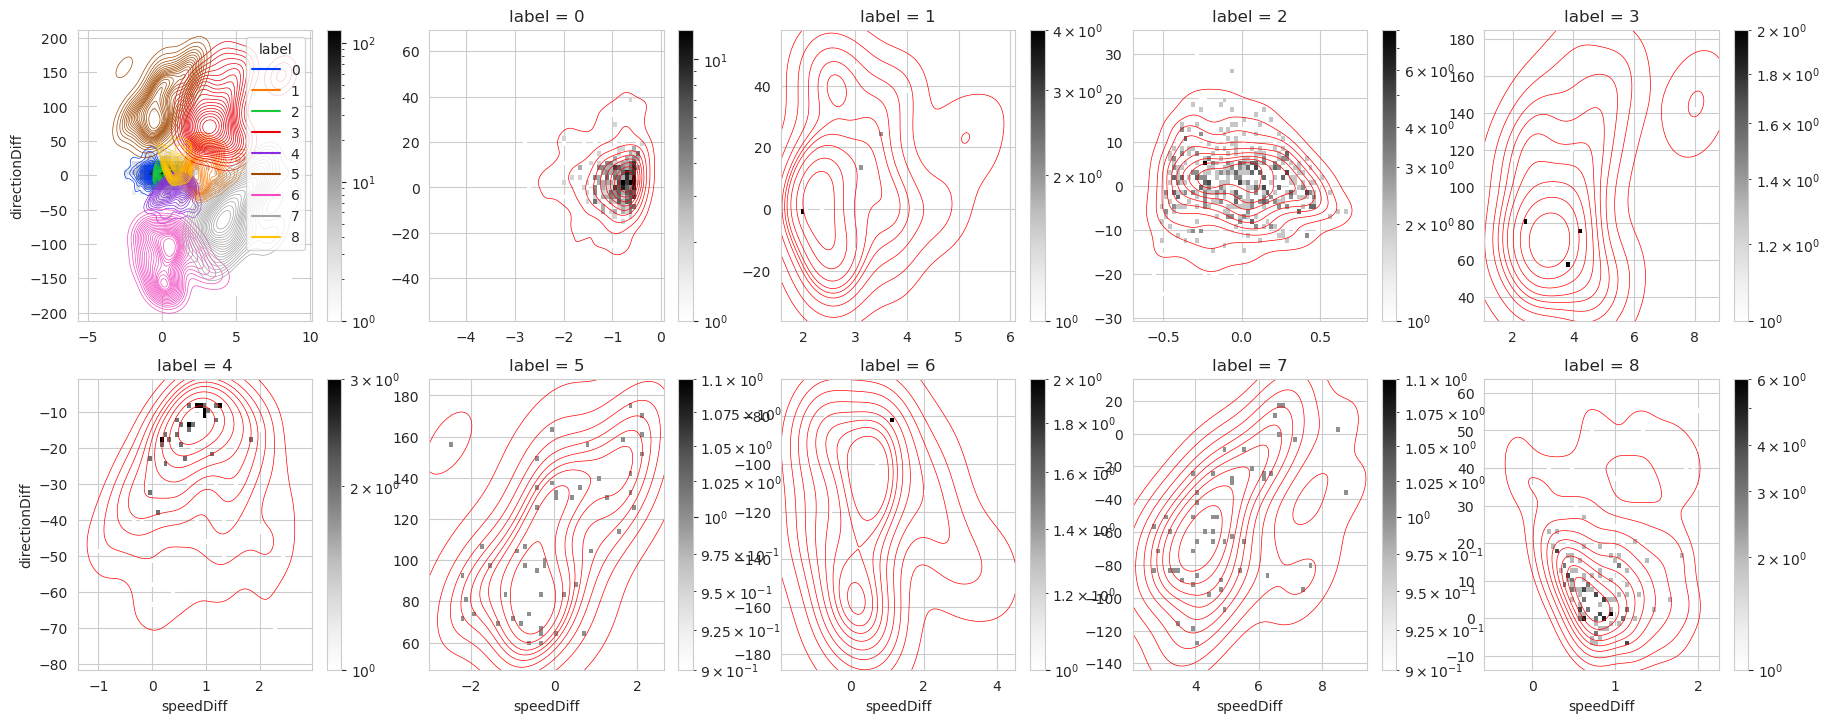

In [63]:
pdfPlotTest('speedDiff', 'directionDiff', df, nx = 50, ny =50)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='speedDiff', ylabel='directionDiff'>

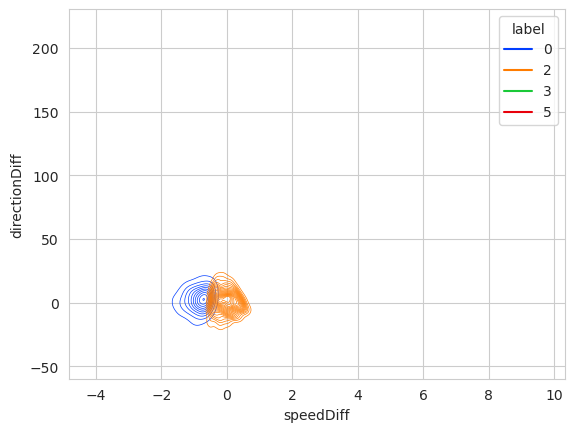

In [64]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [65]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

SyntaxError: invalid syntax (1772201387.py, line 4)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)